#### Import operation data (ratings_small.csv)

In [1]:
import datetime
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import sparse
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ratings_small.csv - memory usage: 3.1 MB
# ratings.csv - memory usage: 794.2 MB

ratings_small = pd.read_csv('C:/Users/Krystian/OneDrive - Politechnika Warszawska/sem6/proj inz/The Movies Dataset/data/ratings_small.csv', low_memory=False)
cleaned_movies_metadata = pd.read_csv('data/cleaned_movies_metadata.csv', low_memory=False)

In [3]:
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
ratings_small.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


#### Check nulls and duplicates

In [6]:
print(ratings_small.isnull().sum())
print(ratings_small.duplicated().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
0


### Check numbers of unique values for columns

In [7]:
print("number of unique users: ", len(ratings_small['userId'].unique()))
print("number of unique items: ", len(ratings_small['movieId'].unique()))

number of unique users:  671
number of unique items:  9066


#### Visualization

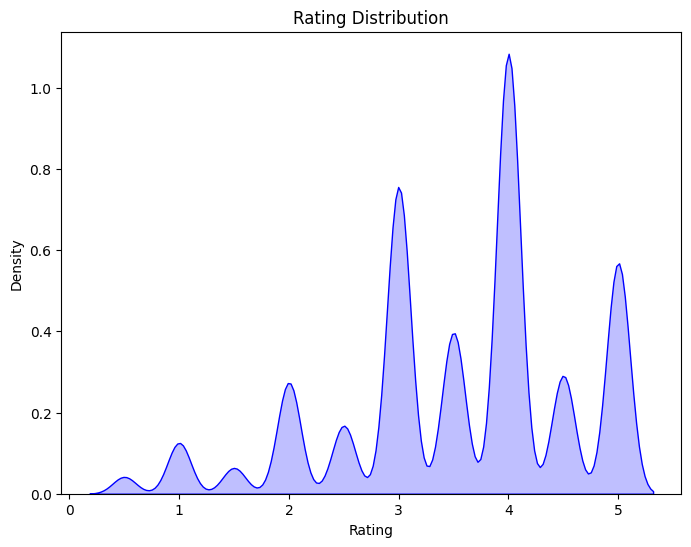

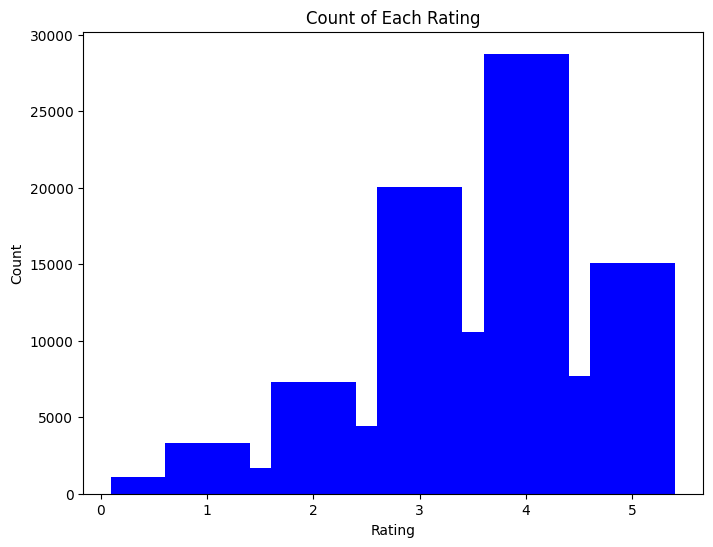

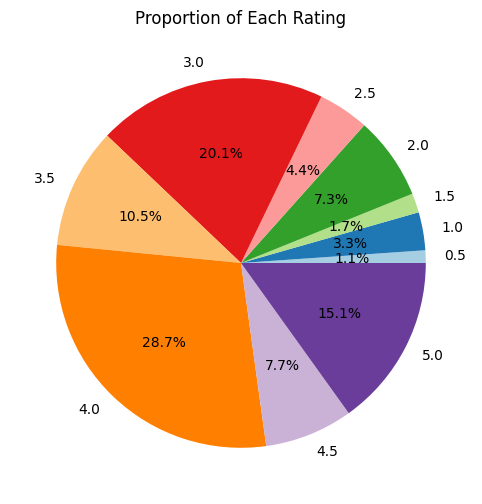

In [8]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x='rating', data=ratings_small, fill=True, color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8, 6))
ratings_count = ratings_small['rating'].value_counts().sort_index()
plt.bar(ratings_count.index, ratings_count.values, color='blue')
plt.title('Count of Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(ratings_count.values, labels=ratings_count.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Proportion of Each Rating')
plt.show()

#### Drop timestamp 

In [9]:
if 'timestamp' in ratings_small.columns:
    ratings_small = ratings_small.drop(columns='timestamp')
ratings_small.head(5)

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [10]:
user_ratings_count = ratings_small.groupby('userId').size().reset_index(name='ratings_count')
top_10_most_ratings = user_ratings_count.nlargest(10, 'ratings_count')
top_10_least_ratings = user_ratings_count.nsmallest(10, 'ratings_count')
average_ratings_per_user = user_ratings_count['ratings_count'].mean()

print('\ttop_10_most_ratings: \n')
print(top_10_most_ratings.head(10))


print('\n\n\ttop_10_least_ratings: \n')
print(top_10_least_ratings.head(10))

print("\n\nMax number of ratings that a user made: ", top_10_most_ratings.iloc[0]['ratings_count'])
print("Min number of ratings that a user made: ", top_10_least_ratings.iloc[-1]['ratings_count'])
print("Average ratings per user: ", average_ratings_per_user)

	top_10_most_ratings: 

     userId  ratings_count
546     547           2391
563     564           1868
623     624           1735
14       15           1700
72       73           1610
451     452           1340
467     468           1291
379     380           1063
310     311           1019
29       30           1011


	top_10_least_ratings: 

     userId  ratings_count
0         1             20
13       14             20
34       35             20
75       76             20
208     209             20
220     221             20
248     249             20
288     289             20
295     296             20
309     310             20


Max number of ratings that a user made:  2391
Min number of ratings that a user made:  20
Average ratings per user:  149.03725782414307


#### Users per their mean ratings

In [11]:
mean_ratings = ratings_small.groupby('userId')['rating'].mean()
mean_ratings.columns = ['userId', 'rating'] 

# low_ratings = mean_ratings.sort_values(by='rating').head()
# high_ratings = mean_ratings.sort_values(by='rating', ascending=False).head()

low_ratings = mean_ratings.sort_values().head()
high_ratings = mean_ratings.sort_values( ascending=False).head()

print("\nhigh_ratings: \n", high_ratings)
print("\nlow_ratings: \n", low_ratings)

bad_rating_user_id = low_ratings.index[0]
good_rating_user_id = high_ratings.index[0]
print("\n\nbad_rating_user_id: ", bad_rating_user_id)
print("good_rating_user_id: ", good_rating_user_id)


high_ratings: 
 userId
46     4.948718
443    4.850000
298    4.800000
448    4.750000
622    4.725806
Name: rating, dtype: float64

low_ratings: 
 userId
579    1.333333
581    1.459184
207    1.804348
609    1.985714
429    2.240741
Name: rating, dtype: float64


bad_rating_user_id:  579
good_rating_user_id:  46


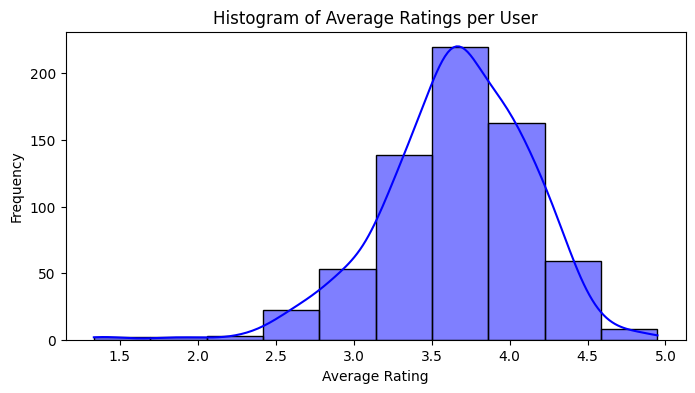

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(mean_ratings, bins=10, kde=True, color='blue')
plt.title('Histogram of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

#### Lets see details for contrasting users 

In [13]:
print("Sample opinions of the user who rates the films the worst: \n")
print(ratings_small[ratings_small['userId'] == bad_rating_user_id].head(10))

print("\n\nSample opinions of the user who rates the videos the best: \n")
print(ratings_small[ratings_small['userId'] == good_rating_user_id].head(10))

Sample opinions of the user who rates the films the worst: 

       userId  movieId  rating
86468     579       65     0.5
86469     579       88     0.5
86470     579     1013     2.0
86471     579     1687     0.5
86472     579     1892     0.5
86473     579     2082     0.5
86474     579     2139     0.5
86475     579     2141     0.5
86476     579     2193     0.5
86477     579     2402     0.5


Sample opinions of the user who rates the videos the best: 

      userId  movieId  rating
7298      46       73     5.0
7299      46      355     5.0
7300      46      724     5.0
7301      46     1270     5.0
7302      46     1359     4.5
7303      46     1515     5.0
7304      46     1707     5.0
7305      46     1965     5.0
7306      46     2153     5.0
7307      46     2379     5.0


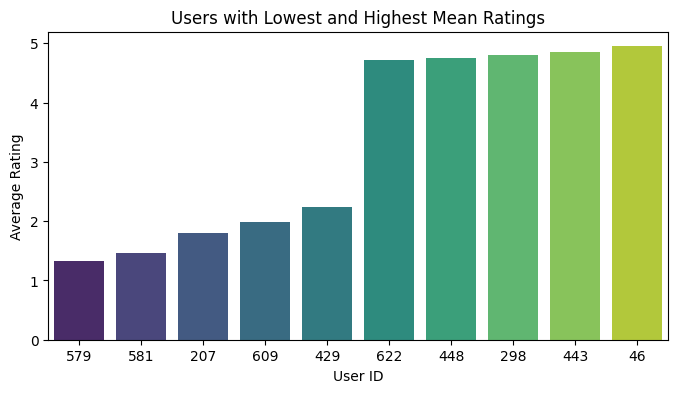

In [14]:
combined_ratings = pd.concat([low_ratings, high_ratings])
combined_ratings = combined_ratings.reset_index()
combined_ratings.columns = ['userId', 'average_rating']
combined_ratings = combined_ratings.sort_values(by='average_rating')
plt.figure(figsize=(8, 4))
sns.barplot(x='userId', y='average_rating', data=combined_ratings, palette='viridis', order=combined_ratings['userId'])
plt.title('Users with Lowest and Highest Mean Ratings')
plt.xlabel('User ID')
plt.ylabel('Average Rating')
plt.show()

#### Clean data

In [15]:
initial_user_count = ratings_small['userId'].nunique()
user_rating_counts = ratings_small.groupby('userId').size()
filtered_users = user_rating_counts[user_rating_counts >= 20].index
filtered_ratings = ratings_small[ratings_small['userId'].isin(filtered_users)]
filtered_user_count = filtered_ratings['userId'].nunique()
user_reduction = initial_user_count - filtered_user_count
initial_ratings_count = ratings_small.shape[0]
high_ratings = filtered_ratings[filtered_ratings['rating'] > 3]
final_ratings_count = high_ratings.shape[0]
ratings_reduction = initial_ratings_count - final_ratings_count

movie_rating_counts = high_ratings.groupby('movieId').size()
filtered_movies = movie_rating_counts[movie_rating_counts >= 20].index
ratings_small = high_ratings[high_ratings['movieId'].isin(filtered_movies)]


print("Initial number of users:", initial_user_count)
print("Number of users after filtering:", filtered_user_count)
print("Reduction in number of users:", user_reduction)

print("\nInitial number of all ratings:", initial_ratings_count)
print("Number of ratings after filtering:", final_ratings_count)
print("Reduction in number of ratings:", ratings_reduction)


Initial number of users: 671
Number of users after filtering: 671
Reduction in number of users: 0

Initial number of all ratings: 100004
Number of ratings after filtering: 62106
Reduction in number of ratings: 37898


In [16]:
# ratings.csv - memory usage: 466.4 MB
# ratings_small.csv - memory usage: 1.2 MB
ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39032 entries, 4 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   39032 non-null  int64  
 1   movieId  39032 non-null  int64  
 2   rating   39032 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.2 MB


In [17]:
ratings_small['rating'] = 1

In [18]:
# Toy Story
ratings_small[ratings_small['movieId'] == 1].head(10)

,userId,movieId,rating
699,9,1,1
889,13,1,1
3528,20,1,1
4781,26,1,1
5048,30,1,1
6625,37,1,1
7142,43,1,1
7252,44,1,1
7337,47,1,1
7375,48,1,1


In [19]:
print("number of unique users: ", len(ratings_small['userId'].unique()))
print("number of unique items: ", len(ratings_small['movieId'].unique()))

number of unique users:  671
number of unique items:  799


#### Prepare ratings based on movies_metadata.csv and links.csv

In [20]:
cleaned_movies_metadata = pd.read_csv('data/cleaned_movies_metadata.csv')
print(cleaned_movies_metadata.head(10))
print(cleaned_movies_metadata.info())

print("\n\nNumber of films in cleaned_movies_metadata: ", cleaned_movies_metadata.shape[0])

      id  imdb_id                        title
0    862   114709                    Toy Story
1   8844   113497                      Jumanji
2  15602   113228             Grumpier Old Men
3  31357   114885            Waiting to Exhale
4  11862   113041  Father of the Bride Part II
5    949   113277                         Heat
6  11860   114319                      Sabrina
7  45325   112302                 Tom and Huck
8   9091   114576                 Sudden Death
9    710   113189                    GoldenEye
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45413 entries, 0 to 45412
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       45413 non-null  int64 
 1   imdb_id  45413 non-null  int64 
 2   title    45413 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.0+ MB
None


Number of films in cleaned_movies_metadata:  45413


In [21]:
cleaned_links = pd.read_csv('data/cleaned_links.csv')
print(cleaned_links.head(10))
print(cleaned_links.info())

print("\n\nNumber of films in cleaned_links: ", cleaned_links.shape[0])

   movieId  imdbId
0        1  114709
1        2  113497
2        3  113228
3        4  114885
4        5  113041
5        6  113277
6        7  114319
7        8  112302
8        9  114576
9       10  113189
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  45843 non-null  int64
 1   imdbId   45843 non-null  int64
dtypes: int64(2)
memory usage: 716.4 KB
None


Number of films in cleaned_links:  45843


#### Filter links for movies that are in cleaned_movies_metadata beased on imdb_id

In [22]:
filtered_links = cleaned_links[cleaned_links['imdbId'].isin(cleaned_movies_metadata['imdb_id'])]
print(filtered_links.head())

   movieId  imdbId
0        1  114709
1        2  113497
2        3  113228
3        4  114885
4        5  113041


In [23]:
print("Number of films in filtered_links: ", filtered_links.shape[0])

Number of films in filtered_links:  45350


#### Filter ratings based on filtred_links

In [24]:
filtered_ratings = ratings_small[ratings_small['movieId'].isin(filtered_links['movieId'])]

In [25]:
filtered_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38977 entries, 4 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userId   38977 non-null  int64
 1   movieId  38977 non-null  int64
 2   rating   38977 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


In [26]:
# Before
print("number of unique items: ", len(ratings_small['movieId'].unique()))

# After
print("number of unique items: ", len(filtered_ratings['movieId'].unique()))

number of unique items:  799
number of unique items:  797


In [27]:
filtered_ratings

,userId,movieId,rating
4,1,1172,1
8,1,1339,1
12,1,1953,1
13,1,2105,1
20,2,10,1
...,...,...,...
99995,671,5989,1
99996,671,5991,1
99997,671,5995,1
100001,671,6365,1


In [28]:
filtered_ratings = filtered_ratings.merge(filtered_links[['movieId', 'imdbId']], on='movieId', how='left')
filtered_ratings = filtered_ratings.drop(columns=['movieId'])
filtered_ratings = filtered_ratings.rename(columns={'imdbId': 'imdb_id'})

In [29]:
unique_imdb_ids = filtered_ratings['imdb_id'].unique()
imdb_id_to_new_id = {imdb_id: idx for idx, imdb_id in enumerate(unique_imdb_ids)}

unique_user_ids = filtered_ratings['userId'].unique()
user_id_to_new_id = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}

In [30]:
filtered_ratings['new_imdb_id'] = filtered_ratings['imdb_id'].map(imdb_id_to_new_id)
filtered_ratings['new_user_id'] = filtered_ratings['userId'].map(user_id_to_new_id)

filtered_ratings = filtered_ratings.drop(columns=['imdb_id', 'userId'])
filtered_ratings = filtered_ratings.rename(columns={'new_imdb_id': 'movieId', 'new_user_id': 'userId'})

filtered_ratings = filtered_ratings[['userId', 'movieId', 'rating']]

imdb_id_mapping = pd.DataFrame(list(imdb_id_to_new_id.items()), columns=['imdb_id', 'new_imdb_id'])
user_id_mapping = pd.DataFrame(list(user_id_to_new_id.items()), columns=['userId', 'new_user_id'])

imdb_id_mapping.to_csv('data/imdb_id_mapping.csv', index=False)
user_id_mapping.to_csv('data/user_id_mapping.csv', index=False)

filtered_ratings.to_csv('data/filtered_ratings_with_new_ids.csv', index=False)

In [31]:
filtered_ratings

,userId,movieId,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,1,4,1
...,...,...,...
38972,670,282,1
38973,670,698,1
38974,670,201,1
38975,670,626,1


In [32]:
filtered_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38977 entries, 0 to 38976
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userId   38977 non-null  int64
 1   movieId  38977 non-null  int64
 2   rating   38977 non-null  int64
dtypes: int64(3)
memory usage: 913.6 KB


In [36]:
unique_users = filtered_ratings['userId'].unique()
unique_movies = filtered_ratings['movieId'].unique()

full_index = pd.MultiIndex.from_product([unique_users, unique_movies], names=['userId', 'movieId'])
full_df = pd.DataFrame(index=full_index).reset_index()

full_ratings = pd.merge(full_df, filtered_ratings, on=['userId', 'movieId'], how='left').fillna(0)

full_ratings['rating'] = full_ratings['rating'].astype(int)


print(full_ratings.head(20))

    userId  movieId  rating
0        0        0       1
1        0        1       1
2        0        2       1
3        0        3       1
4        0        4       0
5        0        5       0
6        0        6       0
7        0        7       0
8        0        8       0
9        0        9       0
10       0       10       0
11       0       11       0
12       0       12       0
13       0       13       0
14       0       14       0
15       0       15       0
16       0       16       0
17       0       17       0
18       0       18       0
19       0       19       0


In [39]:
full_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534787 entries, 0 to 534786
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   534787 non-null  int64
 1   movieId  534787 non-null  int64
 2   rating   534787 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 10.2 MB


In [38]:
full_ratings.to_csv('data/full_ratings.csv', index=False)